In [1]:
import os
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import json

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn


from transformers import AutoConfig, AutoModel, AutoModelForSequenceClassification, AutoTokenizer
from transformers import GlueDataTrainingArguments as DataTrainingArguments, TrainingArguments
from transformers import GlueDataset, default_data_collator, Trainer, glue_compute_metrics

from train_test_overlap_utils import CBOW, build_compute_metrics_fn

os.environ["WANDB_DISABLED"] = "true"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [3]:
mnli_hard_data_args = DataTrainingArguments(task_name = 'mnli',
                                       max_seq_length= 96,
                                       data_dir = '/home/nlp/cartography/filtered/' + 'bert_base' + '_hard_mnli/cartography_confidence_0.05/MNLI')

mnli_easy_data_args = DataTrainingArguments(task_name = 'mnli',
                                       max_seq_length= 96,
                                       data_dir = '/home/nlp/cartography/filtered/' + 'bert_base' + '_easy_mnli/cartography_confidence_0.05/MNLI')

mnli_ambiguous_data_args = DataTrainingArguments(task_name = 'mnli',
                                       max_seq_length= 96,
                                       data_dir = '/home/nlp/cartography/filtered/' + 'bert_base' + '_ambiguous_mnli/cartography_variability_0.05/MNLI')


mnli_data_args = DataTrainingArguments(task_name = 'mnli',
                                       max_seq_length= 96,
                                       data_dir = '/home/nlp/data/glue_data/MNLI')

mnli_train_dataset = GlueDataset(mnli_data_args, tokenizer, mode="train")
mnli_valid_dataset = GlueDataset(mnli_data_args, tokenizer, mode="dev")

mnli_easy_dataset = GlueDataset(mnli_easy_data_args, tokenizer, mode="train")
mnli_ambiguous_dataset = GlueDataset(mnli_ambiguous_data_args, tokenizer, mode="train")
mnli_hard_dataset = GlueDataset(mnli_hard_data_args, tokenizer, mode="train")

/home/nlp/.local/lib/python3.8/site-packages/transformers/data/datasets/glue.py:87: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(
/home/nlp/.local/lib/python3.8/site-packages/transformers/data/processors/glue.py:222: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


In [4]:
mnli_mm_data_args = DataTrainingArguments(task_name = 'mnli-mm',
                                       max_seq_length= 96,
                                       data_dir = '/home/nlp/data/glue_data/MNLI')
mnli_mm_valid_dataset = GlueDataset(mnli_mm_data_args, tokenizer, mode="dev")

/home/nlp/.local/lib/python3.8/site-packages/transformers/data/processors/glue.py:268: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


In [8]:
training_args = TrainingArguments(output_dir='/home/nlp/experiments/train_test_overlap', 
                                  seed=42, 
                                  per_device_train_batch_size = 64, #4096,
                                  per_device_eval_batch_size=64, #4096,
                                  logging_steps=25,
                                  num_train_epochs=4)

In [7]:
config = AutoConfig.from_pretrained('bert-base-uncased')
model = CBOW(config)

In [5]:
model = AutoModelForSequenceClassification.from_pretrained('../../experiments/big_small/bert_base/epoch_4')

In [52]:
# torch.cuda.set_device(1)

In [9]:
trainer = Trainer(model=model,
                 args=training_args,
                 train_dataset=mnli_train_dataset,
                 eval_dataset=mnli_mm_valid_dataset,
                 tokenizer=tokenizer,
                 data_collator=default_data_collator,
                 compute_metrics=build_compute_metrics_fn('mnli'))

In [9]:
trainer.train()

/home/nlp/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
25,1.847700
50,1.133700
75,1.115900
100,1.096400
125,1.075000
150,1.060100
175,1.050000


TrainOutput(global_step=192, training_loss=1.1836335062980652, metrics={'train_runtime': 146.3591, 'train_samples_per_second': 1.312, 'total_flos': 0, 'epoch': 4.0})

In [10]:
trainer.evaluate()

/home/nlp/.local/lib/python3.8/site-packages/transformers/data/metrics/__init__.py:66: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/home/nlp/.local/lib/python3.8/site-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


{'eval_loss': 1.0526033639907837,
 'eval_mnli/acc': 0.4360672440142639,
 'eval_runtime': 0.4024,
 'eval_samples_per_second': 24390.271,
 'epoch': 4.0}

In [32]:
# trainer.save_model()

In [134]:
naive_valid_preds_obj = trainer.predict(mnli_valid_dataset)
naive_train_preds_obj = trainer.predict(mnli_train_dataset)

In [85]:
bert_valid_preds_obj = trainer.predict(mnli_valid_dataset)

In [88]:
bert_train_preds_obj = trainer.predict(mnli_train_dataset)

In [10]:
bert_valid_mm_preds_obj = trainer.predict(mnli_mm_valid_dataset)

/home/nlp/.local/lib/python3.8/site-packages/transformers/data/metrics/__init__.py:66: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/home/nlp/.local/lib/python3.8/site-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


In [135]:
naive_valid_preds = []
naive_train_preds = []

for preds in naive_valid_preds_obj.predictions:
    naive_valid_preds.append(np.argmax(preds))
    
for preds in naive_train_preds_obj.predictions:
    naive_train_preds.append(np.argmax(preds))

In [89]:
bert_valid_preds = []
bert_train_preds = []

for preds in bert_valid_preds_obj.predictions:
    bert_valid_preds.append(np.argmax(preds))
    
for preds in bert_train_preds_obj.predictions:
    bert_train_preds.append(np.argmax(preds))

In [11]:
bert_valid_mm_preds = []

for preds in bert_valid_mm_preds_obj.predictions:
    bert_valid_mm_preds.append(np.argmax(preds))

In [90]:
# with open('/home/nlp/experiments/train_test_overlap/bert_solved_indices_valid.npy', 'wb') as f:
#     np.save(f, bert_valid_solved_indices)
    
# with open('/home/nlp/experiments/train_test_overlap/bert_solved_indices_train.npy', 'wb') as f:
#     np.save(f, bert_train_solved_indices)

In [ ]:
# with open('/home/nlp/experiments/train_test_overlap/bert_solved_indices_valid.npy', 'wb') as f:
#     np.save(f, bert_valid_solved_indices)

In [136]:
naive_valid_solved_indices = np.where(naive_valid_preds_obj.label_ids == np.array(naive_valid_preds))[0]
naive_train_solved_indices = np.where(naive_train_preds_obj.label_ids == np.array(naive_train_preds))[0]

In [41]:
bert_valid_solved_indices = np.where(bert_valid_preds_obj.label_ids == np.array(bert_valid_preds))[0]
bert_train_solved_indices = np.where(bert_train_preds_obj.label_ids == np.array(bert_train_preds))[0]

In [12]:
bert_valid_mm_solved_indices = np.where(bert_valid_mm_preds_obj.label_ids == np.array(bert_valid_mm_preds))[0]

In [137]:
# with open('/home/nlp/experiments/train_test_overlap/solved_indices_valid.npy', 'wb') as f:
#     np.save(f, naive_valid_solved_indices)
    
# with open('/home/nlp/experiments/train_test_overlap/solved_indices_train.npy', 'wb') as f:
#     np.save(f, naive_train_solved_indices)

In [338]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('paraphrase-distilroberta-base-v1')

In [339]:
mnli_train_dataset

InputFeatures(input_ids=[101, 17158, 2135, 6949, 8301, 25057, 2038, 2048, 3937, 9646, 1011, 4031, 1998, 10505, 1012, 102, 4031, 1998, 10505, 2024, 2054, 2191, 6949, 8301, 25057, 2147, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [353]:
embeddings1 = model.encode(mnli_train_sentences, device='cuda')
embeddings2 = model.encode(mnli_valid_sentences[0], device='cuda')

In [357]:
embeddings2.shape

(768,)

In [358]:
cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)

In [361]:
cosine_scores.argmax()

tensor(225724)

In [362]:
cosine_scores[225724]

tensor([0.4772])

In [350]:
mnli_train_sentences[0]

'conceptually cream skimming has two basic dimensions - product and geography. product and geography are what make cream skimming work.'

In [340]:
mnli_train_sentences = []
mnli_valid_sentences = []

for sent in tqdm(mnli_train_dataset):
    mnli_train_sentences.append(tokenizer.decode(sent.input_ids, skip_special_tokens=True).lower())
    
for sent in tqdm(mnli_valid_dataset):
    mnli_valid_sentences.append(tokenizer.decode(sent.input_ids, skip_special_tokens=True).lower())

100%|██████████| 9815/9815 [00:01<00:00, 9321.72it/s]


In [48]:
# mnli_train_embeddings = []
# for sent in tqdm(mnli_train_sentences):
#     mnli_train_embeddings.append(model.encode(sent, convert_to_tensor=True))

100%|██████████| 392702/392702 [44:00<00:00, 148.74it/s]


In [49]:
# mnli_valid_embeddings = []
# for sent in tqdm(mnli_valid_sentences):
#     mnli_valid_embeddings.append(model.encode(sent, convert_to_tensor=True))

100%|██████████| 9815/9815 [01:06<00:00, 147.95it/s]


In [21]:
import re
from collections import Counter
import math

pattern = re.compile('[\W_]+')

In [42]:
# cosine_dict = []

# # for idx, valid_sent in tqdm(enumerate(mnli_valid_embeddings)):
# for idx, valid_sent in tqdm(enumerate(mnli_valid_sentences)):
#     valid_sent = pattern.sub(' ', valid_sent)
#     temp_dict = {}
#     max_val = 0
#     sim_sent = ""
    
# #     for train_sent in mnli_train_embeddings:
# #         cosine_score = util.pytorch_cos_sim(train_sent, valid_sent)[0][0].item()
#     for train_sent in mnli_train_sentences:
#         train_sent = pattern.sub(' ', train_sent)
#         cosine_score = cosine_similarity_ngrams(valid_sent.split(), train_sent.split())
#         if cosine_score > max_val:
#             max_val = cosine_score
#             sim_sent = train_sent
            
#     temp_dict['sim_sent'] = sim_sent
#     temp_dict['max_val'] = max_val
#     cosine_dict.append(temp_dict)
    
#     print('Cosine: ', max_val)
#     print('Valid: ', mnli_valid_sentences[idx])
#     print('Train: ', mnli_train_sentences[idx])
#     print()

In [14]:
import pickle

In [17]:
solved_indices_valid = np.load("/home/nlp/experiments/train_test_overlap/solved_indices_valid.npy")
solved_indices_train = np.load("/home/nlp/experiments/train_test_overlap/solved_indices_train.npy")

In [15]:
with open("/home/nlp/experiments/train_test_overlap/similarity-mm-lo.bin", "rb") as f:
    sim_data = pickle.load(f)

In [18]:
for i in range(len(sim_data)):
    if sim_data[i]['train_idx'] in solved_indices_train:
        sim_data[i]['naive_train'] = 1
    else:
        sim_data[i]['naive_train'] = 0
    
    if sim_data[i]['valid_idx'] in solved_indices_valid:
        sim_data[i]['naive_valid'] = 1
    else:
        sim_data[i]['naive_valid'] = 0
    sim_data[i]['cartography'] = None

In [36]:
mnli_hard_data_args = DataTrainingArguments(task_name = 'mnli',
                                       max_seq_length= 96,
                                       data_dir = '/home/nlp/cartography/filtered/' + 'bert_base' + '_hard_mnli/cartography_confidence_0.75/MNLI')

mnli_easy_data_args = DataTrainingArguments(task_name = 'mnli',
                                       max_seq_length= 96,
                                       data_dir = '/home/nlp/cartography/filtered/' + 'bert_base' + '_easy_mnli/cartography_confidence_0.75/MNLI')

mnli_ambiguous_data_args = DataTrainingArguments(task_name = 'mnli',
                                       max_seq_length= 96,
                                       data_dir = '/home/nlp/cartography/filtered/' + 'bert_base' + '_ambiguous_mnli/cartography_variability_0.75/MNLI')


mnli_data_args = DataTrainingArguments(task_name = 'mnli',
                                       max_seq_length= 96,
                                       data_dir = '/home/nlp/data/glue_data/MNLI')

# mnli_train_dataset = GlueDataset(mnli_data_args, tokenizer, mode="train")
# mnli_valid_dataset = GlueDataset(mnli_data_args, tokenizer, mode="dev")

mnli_easy_dataset = GlueDataset(mnli_easy_data_args, tokenizer, mode="train")
mnli_ambiguous_dataset = GlueDataset(mnli_ambiguous_data_args, tokenizer, mode="train")
mnli_hard_dataset = GlueDataset(mnli_hard_data_args, tokenizer, mode="train")

RuntimeError: [enforce fail at inline_container.cc:222] . file not found: archive/data.pkl

In [ ]:
mnli_easy_sentences = []
mnli_ambiguous_sentences = []
mnli_hard_sentences = []

for sent in tqdm(mnli_easy_dataset):
    mnli_easy_sentences.append(pattern.sub(' ', tokenizer.decode(sent.input_ids, skip_special_tokens=True)))
    
for sent in tqdm(mnli_ambiguous_dataset):
    mnli_ambiguous_sentences.append(pattern.sub(' ', tokenizer.decode(sent.input_ids, skip_special_tokens=True)))
    
for sent in tqdm(mnli_hard_dataset):
    mnli_hard_sentences.append(pattern.sub(' ', tokenizer.decode(sent.input_ids, skip_special_tokens=True)))

In [ ]:
for i in trange(len(sim_data)):
#     easy_flag, ambiguous_flag, hard_flag = False, False, False
    
    if sim_data[i]['cartography'] is not None:
        continue
    
    sent = sim_data[i]['sim_sent']
    sent = pattern.sub(' ', sent)
    
    for easy_item, ambi_item, hard_item in zip(mnli_easy_sentences, mnli_ambiguous_dataset, mnli_hard_sentences):
        if sent == easy_item:
            sim_data[i]['cartography'] = 'easy'
            break
        if sent == ambi_item:
            sim_data[i]['cartography'] = 'ambiguous'
            break
        if sent == hard_item:
            sim_data[i]['cartography'] = 'hard'
            break

In [37]:
cnt = 0
for i in sim_data:
    if i['cartography'] is not None:
        cnt += 1
print(cnt)

345


In [26]:
len(mnli_valid_dataset)

9815

In [45]:
for i in range(len(sim_data)):
    sim_data[i]['max_val'] = sim_data[i]['max_val'].item()
    sim_data[i]['train_idx'] = sim_data[i]['train_idx'].item()

In [46]:
# with open("/home/nlp/experiments/train_test_overlap/total_sim_sts.json", "w") as f:
#     json.dump(sim_data, f)

In [24]:
with open("/home/nlp/experiments/train_test_overlap/total_sim_sts.json", "r") as f:
    sim_data = json.load(f)

In [38]:
easy_cnt = 0
ambi_cnt = 0
hard_cnt = 0

for i in sim_data:
    if i['cartography'] == 'easy':
        easy_cnt += 1
    if i['cartography'] == 'ambiguous':
        ambi_cnt += 1
    if i['cartography'] == 'hard':
        hard_cnt += 1

In [39]:
easy_cnt, hard_cnt, ambi_cnt

(149, 196, 0)

In [191]:
max_vals = []
for i in sim_data:
    max_vals.append(i['max_val'])

In [195]:
max_vals.sort()

(array([  46.,  417., 1355., 2441., 2555., 1639.,  715.,  322.,  256.,
          69.]),
 array([0.26967994, 0.34271195, 0.41574396, 0.48877596, 0.56180797,
        0.63483997, 0.70787198, 0.78090398, 0.85393599, 0.92696799,
        1.        ]),
 <a list of 10 Patch objects>)

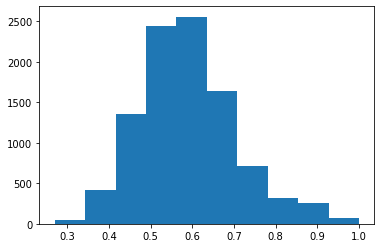

In [206]:
plt.hist(max_vals, bins=10)

In [187]:
# easy_cnt 5011
# hard_cnt 4804

5011

In [40]:
sim_data[0]

{'sim_sent': 'but its not but its not set up as a giveaway if it were set up as giveaway and it was something that i mean our our president and our leaders could be seeking god saying god is it your will for us to bless this nation with this money is it your will this money and your will for us to give to them and i believe if we gave it no strings the churches preach for us to give away things no strings attached',
 'max_val': 0.423355354777398,
 'train_idx': 90278,
 'valid_idx': 0,
 'naive_train': 0,
 'naive_valid': 1,
 'cartography': None}

In [13]:
# total_data = []

# for i in range(len(sim_data)):
#     val = {}
#     val.update(sim_data[i])
#     val['valid'] = tokenizer.decode(mnli_valid_dataset[sim_data[i]['valid_idx']].input_ids,skip_special_tokens=True)
#     val['train'] = tokenizer.decode(mnli_train_dataset[sim_data[i]['train_idx']].input_ids,skip_special_tokens=True)
#     total_data.append(val)
# with open("/home/nlp/experiments/train_test_overlap/data_all.json", "w") as f:
#     json.dump(total_data, f, indent=4)

In [43]:
for i in range(len(sim_data)):
    if i in bert_valid_mm_solved_indices: 
        sim_data[i]['bert_valid_mm'] = 1
    else:
        sim_data[i]['bert_valid_mm'] = 0

In [44]:
for i in range(len(sim_data)):
    if i in bert_train_solved_indices: 
        sim_data[i]['bert_train'] = 1
    else:
        sim_data[i]['bert_train'] = 0

In [45]:
sim_data[100]

{'sim_sent': 'american credibility is at stake. american credibility could become either better or worse.',
 'max_val': 0.5366520881652832,
 'train_idx': 17053,
 'valid_idx': 100,
 'naive_train': 0,
 'naive_valid': 1,
 'cartography': 'hard',
 'bert_valid': 1,
 'bert_train': 1}

In [53]:
for i in sim_data:
    min_val = min(min_val, i['max_val'])

In [41]:
def get_accuracy(min_range, max_range, category):
    bert_accuracy = 0
    naive_accuracy = 0
    cnt = 0
    sim_scores = []
    for i in sim_data:
        if min_range <= i['max_val']*100 <= max_range:
#             if i['cartography'] == category:
            if i['bert_valid_mm'] == 1:
                bert_accuracy += 1
            if i['naive_valid'] == 1:
                naive_accuracy += 1
            sim_scores.append(i['max_val']*0.01)
            cnt += 1
    return naive_accuracy/cnt*100, bert_accuracy/cnt*100, sim_scores

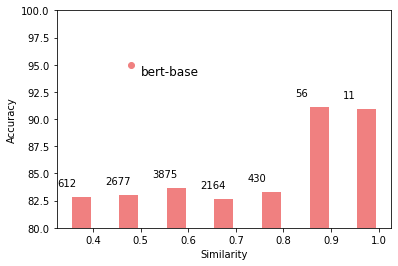

In [44]:
# naive_acc_20_30, bert_acc_20_30, sim_scores_20_30 =  get_accuracy(20, 30, 'easy')
naive_acc_30_40, bert_acc_30_40, sim_scores_30_40 =  get_accuracy(30, 40, 'easy')
naive_acc_40_50, bert_acc_40_50, sim_scores_40_50 =  get_accuracy(40, 50, 'easy')
naive_acc_50_60, bert_acc_50_60, sim_scores_50_60 =  get_accuracy(50, 60, 'easy')
naive_acc_60_70, bert_acc_60_70, sim_scores_60_70 =  get_accuracy(60, 70, 'easy')
naive_acc_70_80, bert_acc_70_80, sim_scores_70_80 =  get_accuracy(70, 80, 'easy')
naive_acc_80_90, bert_acc_80_90, sim_scores_80_90 =  get_accuracy(80, 90, 'easy')
naive_acc_90_100, bert_acc_90_100, sim_scores_90_100 =  get_accuracy(90, 100, 'easy')

width = 0.04

plt.text(0.325, bert_acc_30_40+1, len(sim_scores_30_40))
# plt.bar(0.325, height =  naive_acc_30_40, width=width, color='lightskyblue')
plt.bar(0.375, height =  bert_acc_30_40, width=width, color='lightcoral')

plt.text(0.425, bert_acc_40_50+1, len(sim_scores_40_50))
# plt.bar(0.425, height =  naive_acc_40_50, width=width, color='lightskyblue')
plt.bar(0.475, height =  bert_acc_40_50, width=width, color='lightcoral')

plt.text(0.525, bert_acc_50_60+1, len(sim_scores_50_60))
# plt.bar(0.525, height =  naive_acc_50_60, width=width, color='lightskyblue')
plt.bar(0.575, height =  bert_acc_50_60, width=width, color='lightcoral')

plt.text(0.625, bert_acc_60_70+1, len(sim_scores_60_70))
# plt.bar(0.625, height =  naive_acc_60_70, width=width, color='lightskyblue')
plt.bar(0.675, height =  bert_acc_60_70, width=width, color='lightcoral')

plt.text(0.725, bert_acc_70_80+1, len(sim_scores_70_80))
# plt.bar(0.725, height =  naive_acc_70_80, width=width, color='lightskyblue')
plt.bar(0.775, height =  bert_acc_70_80, width=width, color='lightcoral')

plt.text(0.825, bert_acc_80_90+1, len(sim_scores_80_90))
# plt.bar(0.825, height =  naive_acc_80_90, width=width, color='lightskyblue')
plt.bar(0.875, height =  bert_acc_80_90, width=width, color='lightcoral')

plt.text(0.925, bert_acc_90_100+1, len(sim_scores_90_100))
# plt.bar(0.925, height =  naive_acc_90_100, width=width, color='lightskyblue')
plt.bar(0.975, height =  bert_acc_90_100, width=width, color='lightcoral')

# plt.title('Easy')
plt.ylim(80, 100)


plt.text(0.5, 94, 'bert-base', fontsize=12) 
plt.plot(0.48, 95, marker = 'o', color='lightcoral')

# plt.text(0.50, 94, 'naive', fontsize=12) 
# plt.plot(0.48, 95, marker = 'o', color='lightskyblue') 


plt.ylabel('Accuracy')
plt.xlabel('Similarity')

# plt.savefig('../figs/overlap_merge.pdf')
plt.show()

In [117]:
4699+1585+357+115+19

6775

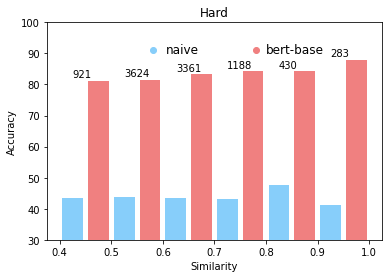

In [52]:
# naive_acc_20_30, bert_acc_20_30, sim_scores_20_30 =  get_accuracy(20, 30, 'hard')
naive_acc_30_40, bert_acc_30_40, sim_scores_30_40 =  get_accuracy(30, 40, 'hard')
naive_acc_40_50, bert_acc_40_50, sim_scores_40_50 =  get_accuracy(40, 50, 'hard')
naive_acc_50_60, bert_acc_50_60, sim_scores_50_60 =  get_accuracy(50, 60, 'hard')
naive_acc_60_70, bert_acc_60_70, sim_scores_60_70 =  get_accuracy(60, 70, 'hard')
naive_acc_70_80, bert_acc_70_80, sim_scores_70_80 =  get_accuracy(70, 80, 'hard')
naive_acc_80_90, bert_acc_80_90, sim_scores_80_90 =  get_accuracy(80, 90, 'hard')
naive_acc_90_100, bert_acc_90_100, sim_scores_90_100 =  get_accuracy(90, 100, 'hard')

# plt.text(0.225, bert_acc_20_30+1, len(sim_scores_20_30))
# plt.bar(0.225, height = naive_acc_20_30, width=width, color='lightskyblue')
# plt.bar(0.275, height =  bert_acc_20_30, width=width, color='lightcoral')

# plt.text(0.325, bert_acc_30_40+1, len(sim_scores_30_40))
# plt.bar(0.325, height =  naive_acc_30_40, width=width, color='lightskyblue')
# plt.bar(0.375, height =  bert_acc_30_40, width=width, color='lightcoral')

plt.text(0.425, bert_acc_40_50+1, len(sim_scores_40_50))
plt.bar(0.425, height =  naive_acc_40_50, width=width, color='lightskyblue')
plt.bar(0.475, height =  bert_acc_40_50, width=width, color='lightcoral')

plt.text(0.525, bert_acc_50_60+1, len(sim_scores_50_60))
plt.bar(0.525, height =  naive_acc_50_60, width=width, color='lightskyblue')
plt.bar(0.575, height =  bert_acc_50_60, width=width, color='lightcoral')

plt.text(0.625, bert_acc_60_70+1, len(sim_scores_60_70))
plt.bar(0.625, height =  naive_acc_60_70, width=width, color='lightskyblue')
plt.bar(0.675, height =  bert_acc_60_70, width=width, color='lightcoral')

plt.text(0.725, bert_acc_70_80+1, len(sim_scores_70_80))
plt.bar(0.725, height =  naive_acc_70_80, width=width, color='lightskyblue')
plt.bar(0.775, height =  bert_acc_70_80, width=width, color='lightcoral')

plt.text(0.825, bert_acc_80_90+1, len(sim_scores_80_90))
plt.bar(0.825, height =  naive_acc_80_90, width=width, color='lightskyblue')
plt.bar(0.875, height =  bert_acc_80_90, width=width, color='lightcoral')

plt.text(0.925, bert_acc_90_100+1, len(sim_scores_90_100))
plt.bar(0.925, height =  naive_acc_90_100, width=width, color='lightskyblue')
plt.bar(0.975, height =  bert_acc_90_100, width=width, color='lightcoral')

plt.text(0.80, 90, 'bert-base', fontsize=12) 
plt.plot(0.78, 91, marker = 'o', color='lightcoral') 

plt.text(0.606, 90, 'naive', fontsize=12) 
plt.plot(0.58, 91, marker = 'o', color='lightskyblue') 

plt.ylim(30, 100)
plt.title('Hard')

plt.ylabel('Accuracy')
plt.xlabel('Similarity')
# plt.savefig('../figs/overlap_hard.pdf')
plt.show()
# g.text(0.5, 0.04, 'Similarity', ha='center')

In [336]:
6+147+952+1767+1335+395+150+68+143+890+1765+1357+545+226+96

9842

In [80]:
240+176+190+107

713